This notebook aims at evaluating 1 or 2 dimensional ranges on a SuMo built through Dakota.

In [1]:
import pathlib as pl
import shutil
import dakota.environment as dakenv
import sys, os
import numpy as np

# script_dir = pl.Path(__file__).parent
script_dir = pl.Path(os.getcwd())  ## how resilient is this?
print(script_dir)
sys.path.append(script_dir)

from utils import funs_create_dakota_conf, funs_data_processing

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation


## Load & process input data

In [2]:
TRAINING_SAMPLES_FILE = "train_Norm20D_1000LHS.dat"
tmp_folder = script_dir / ".tmp_output"
if tmp_folder.exists():
    shutil.rmtree(tmp_folder)
tmp_folder.mkdir()
TRAINING_SAMPLES_FILE = shutil.copy(TRAINING_SAMPLES_FILE, tmp_folder)
PROCESSED_TRAINING_FILE = funs_data_processing.process_input_file(
    TRAINING_SAMPLES_FILE,  # N=100, filter_highest_N=10
)
variables_train = funs_data_processing.get_variable_names(PROCESSED_TRAINING_FILE)
print(variables_train)

['%eval_id', 'RELDEPTH', 'DIAMETER', 'ANGLE', 'ELECTRELDEPTH', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF', 'AFmax_4um', 'GAFmax_4um']


## Sample from input distributions

In [3]:
import pandas as pd
import copy
from create_20D_variables import (
    GEOMETRIC_VARIABLES,
    THICKNESS_VARIABLES,
    CONDUCTIVITY_VARIABLES,
)

In [4]:
N_RESPONSES = 2
if "POSITION" in GEOMETRIC_VARIABLES:
    GEOMETRIC_VARIABLES.pop("POSITION")

dakota_conf_path = tmp_folder / "dakota.in"
dakota_conf = funs_create_dakota_conf.start_dakota_file()
dakota_conf += funs_create_dakota_conf.add_surrogate_model(
    PROCESSED_TRAINING_FILE, cross_validation_folds=None
)
dakota_conf += funs_create_dakota_conf.add_sampling_method(num_samples=1000, seed=None)
# dakota_conf += funs_create_dakota_conf.add_variables(
#     variables=variables_train[1:-N_RESPONSES],
# )
dakota_conf += f"""
    variables
        id_variables = "VARIABLES"
        active uncertain
        uniform_uncertain = {len(GEOMETRIC_VARIABLES)}
            descriptors {" ".join([f"'{var}'" for var in GEOMETRIC_VARIABLES.keys()])}
            upper_bounds {" ".join([str(GEOMETRIC_VARIABLES[var]["upper_bound"]) for var in GEOMETRIC_VARIABLES])}
            lower_bounds {" ".join([str(GEOMETRIC_VARIABLES[var]["lower_bound"]) for var in GEOMETRIC_VARIABLES])}
        normal_uncertain = {len(THICKNESS_VARIABLES)+len(CONDUCTIVITY_VARIABLES)}
            descriptors {" ".join([f"'{var}'" for var in THICKNESS_VARIABLES.keys()])} {" ".join([f"'{var}'" for var in CONDUCTIVITY_VARIABLES.keys()])}
            means {" ".join([str(THICKNESS_VARIABLES[var]["mean"]) for var in THICKNESS_VARIABLES])} {" ".join([str(CONDUCTIVITY_VARIABLES[var]["mean"]) for var in CONDUCTIVITY_VARIABLES])}
            std_deviations {" ".join([str(THICKNESS_VARIABLES[var]["std"]) for var in THICKNESS_VARIABLES])} {" ".join([str(CONDUCTIVITY_VARIABLES[var]["std"]) for var in CONDUCTIVITY_VARIABLES])}
"""
dakota_conf += funs_create_dakota_conf.add_responses(variables_train[-N_RESPONSES:])
print(dakota_conf)
funs_create_dakota_conf.write_to_file(dakota_conf, dakota_conf_path)


    environment
        tabular_data
            tabular_data_file = 'results.dat'
    

        model
            id_model 'SURR_MODEL'
            surrogate global
                gaussian_process surfpack
                ## hopefully faster by removing CV
                import_build_points_file 
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation/.tmp_output/train_Norm20D_1000LHS_processed.txt'
                    custom_annotated header use_variable_labels eval_id 
                export_approx_points_file "predictions.dat"
                export_approx_variance_file "variances.dat"
        
        method
            id_method = 'SAMPLING'
            sample_type
                lhs
            sampling
                samples = 1000
                
            
        
    variables
        id_variables = "VARIABLES"
        active uncertain
        uniform_uncertain = 4
            descriptors 'RELDEPTH' 'DIAMETER' 'ANGL

## Create & run Dakota study

In [5]:
os.chdir(tmp_folder)
shutil.copy(script_dir / "execute_dakota.py", tmp_folder)
!python execute_dakota.py
os.chdir(script_dir)

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation/.tmp_output
Dakota version 6.19+ (stable) released Aug  8 2024.
Repository revision 494027b (2024-04-29) built Aug  8 2024 14:37:02.
Running serial Dakota executable in serial mode.
Start time: Tue Sep 17 19:27:42 2024

Using provided Dakota input string
Writing new restart file 'dakota.rst'.
Surrogate model retrieving points with 19 variables and 2 response
functions from file '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation/.tmp_output/train_Norm20D_1000LHS_processed.txt'

Info (Surrogate model with id 'SURR_MODEL' import_build_points):
Reordering variables imported from tabular file '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation/.tmp_output/train_Norm20D_1000LHS_processed.txt'
based on labels in header.

Surrogate model retrieved 1000 total points.

>>>>> Executing environment.

>>>>> Running random_sampling iterator.

No

## UQ - Input-Output distributions

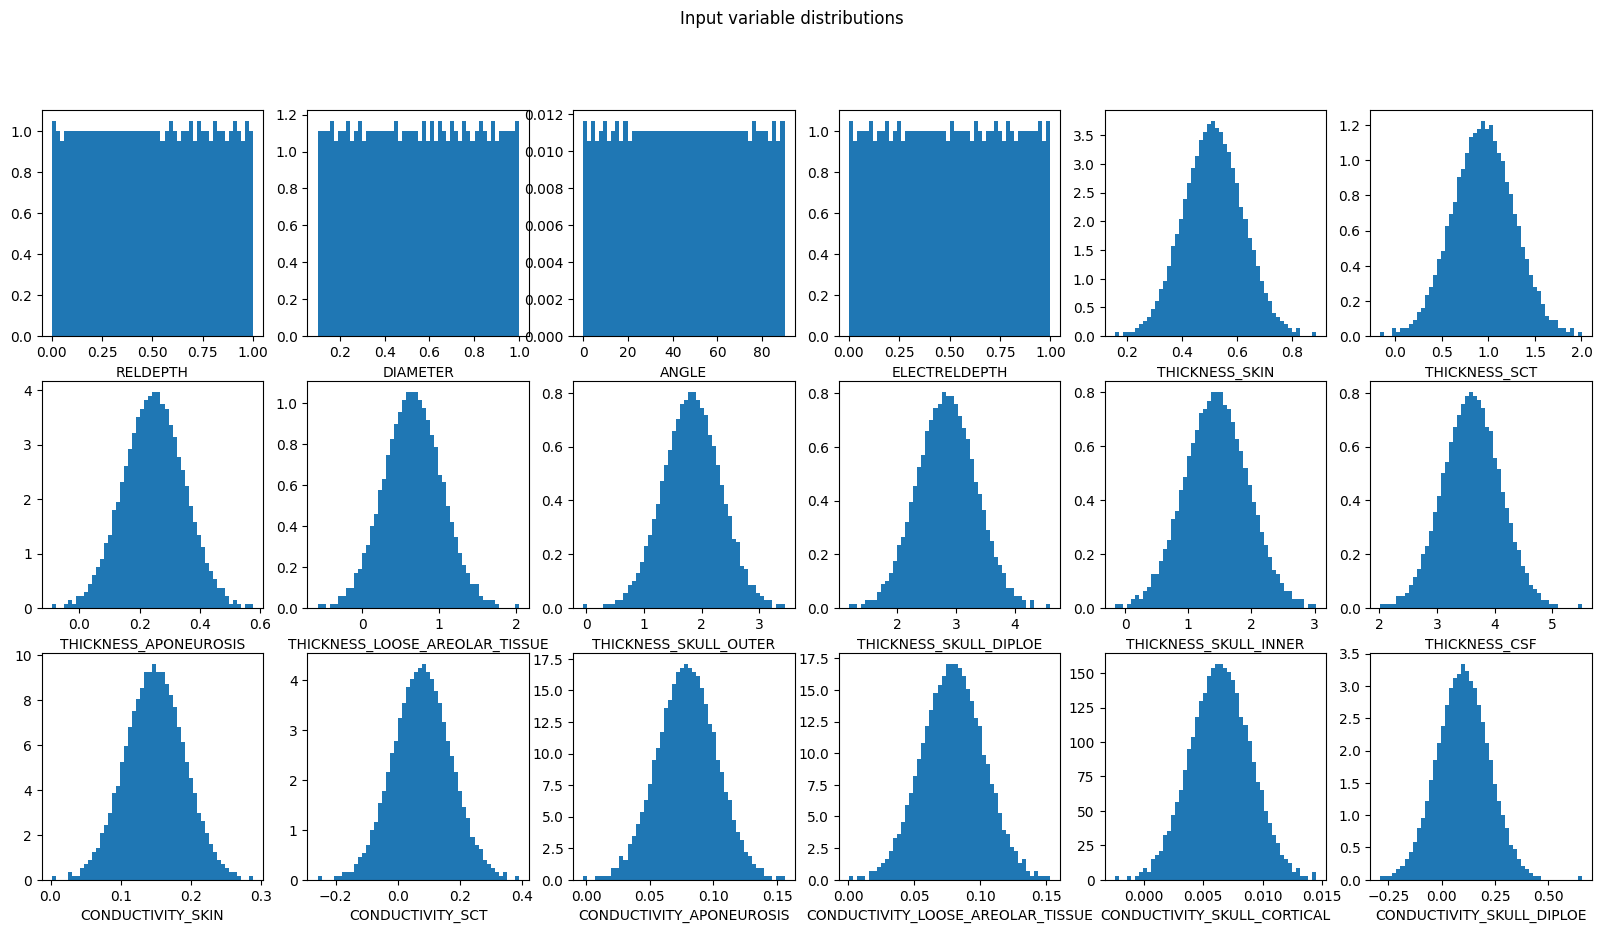

In [6]:
from typing import List
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=False)
axs: List[plt.Axes] = axs.flatten()

for var, ax in zip(variables_train[1:-N_RESPONSES], axs):
    x = funs_data_processing.get_results(tmp_folder / f"predictions.dat", var)
    ax.hist(x, bins=50, density=True)
    ax.set_xlabel(var)
plt.suptitle("Input variable distributions")
plt.show()

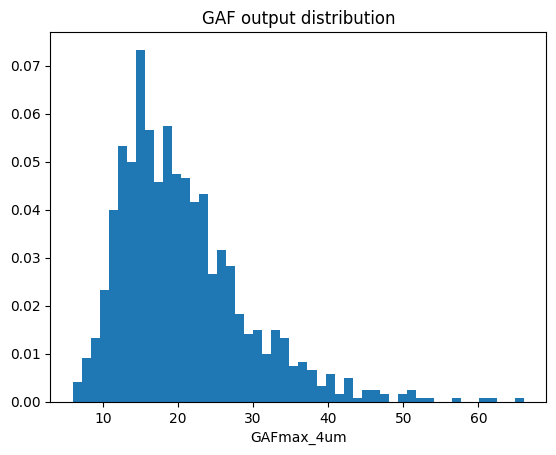

In [7]:
RESPONSE = "GAFmax_4um"

y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", RESPONSE)

plt.hist(y_hat, bins=50, density=True)
plt.title("GAF output distribution")
plt.xlabel(RESPONSE)
plt.show()